## Problem Statement:

With this dataset, I'm trying to predict the genre of music based on certain numerical features, lyrics, track, and album details. This dataset was part of the Data Science Hub Hackathon at Northeastern University. 


The data consists of numerical features like loudness, danceability, energy, mode, and many more. The lyrics column purposely has a lot of noise introduced to mislead. I have used NLTK library to clean the lyrics, remove the noise and create word embeddings. Word embeddings are also created for track and album columns.

In [88]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [89]:
import numpy as np
import pandas as pd 
from gensim.models import Word2Vec, Phrases
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [90]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_column', 1000)

In [91]:
meta1_df = pd.read_csv("meta_data_1.csv")
train_df = pd.read_csv("train.csv")
meta2_df = pd.read_csv("meta_data_2.csv")
#test_df = pd.read_csv("test.csv")

In [92]:
meta1_df.head(10)

,id,adaptibility,danceability,duration,energy,explicit,happening,instrumentalness,loudness,mode,naturality,positiveness,release_date,reputation,speechiness,tempo,time_signature,total_tracks
0,VKpqYUqyes6tjxUE,0,47.8,648405.0,2.94,False,0.1050,0.948000,-45.638,6,0.99300,0.1480,1962,61,0.0453,124.308,3,10
1,Bd8ufO7wOFegZXVz,10,71.0,347181.0,97.90,False,0.1050,0.754000,-6.366,5,0.00263,0.5940,2019-04-17,53,0.0580,145.994,4,1
2,RbsK7ydOf0CWomVN,2,53.9,447695.0,47.00,True,0.1240,0.000000,-12.164,5,0.29900,0.3840,2023-09-29,56,0.0652,129.676,4,17
3,mYx3izxEyO3axauu,7,NaN,376005.0,47.00,False,0.1310,0.000001,-7.840,5,0.13700,0.0569,2023-09-15,61,0.0329,120.006,4,1
4,ECLOwMMomoDb6IM6,0,56.5,408671.0,52.60,False,0.1100,0.000119,-17.704,6,0.03390,0.6370,1971,62,0.0365,167.936,4,10
5,66Yi0zn8OxcimzOj,9,68.5,411445.0,47.20,False,0.2240,0.284000,-14.382,5,0.78500,0.4750,2000-01-01,62,0.0298,80.487,4,27
6,afEyhhwRZSdwvlAG,6,72.1,249135.0,NaN,False,0.1500,0.950000,-14.340,5,0.04260,0.8960,2018-03-30,56,0.0648,105.605,4,6
7,VDlu3HHu9WVMnZeO,0,52.0,407525.0,4.06,False,0.0845,0.000364,-27.794,6,0.87700,0.2850,1952-04-01,70,0.0635,70.138,4,18
8,SeFqFyo5hRUK0IsS,0,30.3,829925.0,49.20,False,0.2880,0.630000,-16.432,6,0.19700,0.6770,1984,48,0.0390,200.018,3,27
9,0aigO7bqrAmImxOi,0,52.6,336155.0,45.90,False,0.2290,0.000000,-12.568,5,0.46400,0.3420,2023-07-21,64,0.1640,139.387,4,1


In [93]:
train_df.head(10)

,song_id,album,artist,lyrics,track,target
0,AA5aMeYP1klLv1BA,Stormy Monday Blues (Sun Records 70th / Remast...,T-Bone Walker,NaN,That Evening Train - Remastered 2022,Blues
1,Wr3MLRGLm08yjrGN,For All The Dogs,Drake,59 ContributorsTranslationsEspañolEnglishPortu...,Bahamas Promises,R&B
2,XtEbP8zIOloM6r5I,Break Out (1983 Version - Expanded Edition),The Pointer Sisters,5 ContributorsInvestigation of the Ferguson Po...,"Automatic - 12"" Special Remix",Disco
3,NW5kIVzyoiV0zJmJ,Legends Never Die,Bad Wolves,3 ContributorsLegends Never Die Lyrics(Yea)\n\...,Legends Never Die,Rock
4,1uhYBNywheqCdzrg,Everything’s Not Lost,Gregory Porter,NaN,Everything’s Not Lost,Jazz
5,fyKA5eI6JWQiTBju,Tyler Hubbard,Tyler Hubbard,6 ContributorsDancin’ In The Country Lyrics[Ve...,Dancin’ In The Country,Country
6,Bdpl6SJGn3YPwFt9,Don't Go To Strangers (Rudy Van Gelder Remaster),Etta Jones,3 ContributorsDon’t Go to Strangers Lyrics[Ver...,Don't Go To Strangers,Jazz
7,FztrB5BsjIK3tNDD,Asceticism,Carl Borg,7 ContributorsThe Picture of Dorian Gray (Chap...,Asceticism,Ambient
8,36dwZtP9EPqsocSM,Global Warming: Meltdown (Deluxe Version),Pitbull,88 ContributorsTranslationsΕλληνικάFeel This M...,Feel This Moment (feat. Christina Aguilera),Pop
9,RXkfxRp0JKXo9gm6,92982,William Basinski,NaN,92982.3,Ambient


In [94]:
meta2_df.head(10)

,id,a1,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a2,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a3,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a4,a40,a41,a42,a43,a44,a45,a46,a47,a48,a49,a5,a50,a6,a7,a8,a9
0,VKpqYUqyes6tjxUE,1296810.0,4.740000,0.12650,62.1540,1.081,2082.827044,25.412184,0.4108,1296810.0,9.413640e-01,-8.5050,62.1540,23.92265,0.002052,2.28200,2.787120,-22.819,2284.84,0.4440,0.015408,84.9730,1.98600,2082.827044,0.05250,2.400000,-2181.4964,0.133182,0.549000,0.021904,-84.9730,4.294440e-02,95.6,15452.478864,8.82,-89.29000,0.709459,2.282524e-07,0.30870,0.986049,5.631152,7.626219e-03,-134.17572,143.0850,0.2960,-190.608,0.2388,15.352,-52.668597,0.02265,2.97900
1,Bd8ufO7wOFegZXVz,694362.0,3.770000,0.34950,72.9970,32.317,40.525956,938313.739000,2.1440,694362.0,1.983020e-03,-293.3850,72.9970,35.52900,0.003364,1.19326,73.816600,-3.183,5041.00,1.7820,0.000592,76.1800,0.00526,40.525956,0.05250,0.480000,-451.9860,5.678200,0.053815,0.352836,-76.1800,4.373200e-02,142.0,21314.248036,293.70,-12.72674,0.176768,1.710923e-06,10.27950,0.000007,8.467652,5.164596e-03,-623.23140,212.6850,1.1880,-281.624,0.1880,11.000,137.251403,0.02900,0.00789
2,RbsK7ydOf0CWomVN,895390.0,0.000000,0.25400,64.8380,20.868,147.962896,103823.000000,1.2752,895390.0,0.000000e+00,-140.6280,64.8380,26.98260,0.004251,1.36600,0.000000,-6.082,2905.21,1.1520,0.001387,70.9200,0.59800,147.962896,0.06200,-1.152000,-655.6396,3.064400,0.211500,0.147456,-70.9200,0.000000e+00,107.8,16815.864976,141.00,-23.73000,0.322917,8.577268e-07,5.82800,0.089401,8.454875,0.000000e+00,-571.70800,161.3280,0.7680,-214.064,0.2352,90.819,35.451403,0.03260,0.89700
3,mYx3izxEyO3axauu,752010.0,0.000006,0.09395,60.0030,NaN,61.465600,103823.000000,0.0960,752010.0,1.534400e-07,-140.6070,60.0030,NaN,0.001082,0.38780,0.000053,-3.920,NaN,0.1707,0.000700,63.9230,0.27400,61.465600,0.06550,-0.170697,NaN,1.546300,0.134000,0.003238,-63.9230,3.684800e-08,NaN,14401.440036,141.00,-15.40600,2.302285,1.513278e-07,6.15700,0.018769,3.948197,9.332867e-09,-368.48000,NaN,0.1138,NaN,0.3924,NaN,35.451403,0.01645,0.41100
4,ECLOwMMomoDb6IM6,817342.0,0.000595,0.37350,83.9680,19.398,313.431616,145531.576000,2.4020,817342.0,4.034100e-06,-157.4700,83.9680,28.26825,0.001332,1.34180,0.006259,-8.852,3192.25,1.9110,0.000694,92.8200,0.06780,313.431616,0.05500,-1.910643,-1000.2760,1.919900,0.071950,0.405769,-92.8200,4.343500e-06,113.0,28202.500096,157.80,-35.34020,0.172684,1.558711e-06,5.78600,0.001149,6.129664,7.086033e-07,-931.23040,169.1700,1.2740,-223.452,0.2940,62.125,46.651403,0.01825,0.10170
5,66Yi0zn8OxcimzOj,822890.0,1.420000,0.34950,40.2435,27.059,206.841924,105154.048000,1.7808,822890.0,2.229400e-01,-140.9280,40.2435,34.26490,0.000888,2.52000,13.404800,-7.191,4692.25,1.4250,0.000631,47.4345,1.57000,206.841924,0.11200,-0.573000,-985.1670,1.406560,0.504500,0.225625,-47.4345,8.463200e-03,137.0,6478.157169,141.60,-27.19400,0.471579,1.154468e-06,10.57280,0.616225,2.398513,3.528520e-03,-678.83040,204.8280,0.9500,-272.100,0.7768,19.125,35.851403,0.01490,2.35500
6,afEyhhwRZSdwvlAG,498270.0,4.750000,0.52300,52.8025,28.880,205.635600,NaN,3.3248,498270.0,4.047000e-02,NaN,52.8025,36.08240,0.004199,1.87720,NaN,-7.170,5198.41,2.6880,NaN,59.9725,0.08520,205.635600,0.07500,0.162000,-1033.9140,NaN,0.096300,0.802816,-59.9725,6.156000e-02,144.2,11152.416025,NaN,-28.59480,0.167411,3.596444e-06,NaN,0.001815,6.843204,8.995786e-03,NaN,215.8500,1.7920,-284.816,0.3408,5.361,NaN,0.03240,0.12780
7,VDlu3HHu9WVMnZeO,815050.0,0.001820,0.18475,35.0690,12.103,772.506436,66.923416,0.8860,815050.0,3.192280e-04,-11.9265,35.0690,26.03175,0.004032,2.32400,0.001478,-13.897,2704.00,0.8550,0.015640,48.9660,1.75400,772.506436,0.04225,-0.853908,-1445.2880,0.257810,0.480750,0.081225,-48.9660,2.311400e-05,104.0,4919.339044,12.18,-53.83400,0.296491,6.993436e-07,0.34307,0.769129,4.453763,5.189769e-06,-112.84364,155.7465,0.5700,-206.860,0.0840,8.000,-50.428597,0.03175,2.63100
8,SeFqFyo5hRUK0IsS,1659850.0,3.150000,0.48250,100.0090,6.934,270.010624,119095.488000,2.5520,165985

 We'll merge metadata1 dataframe with train data frame based on song id. I'm choosing to drop the meta2_df observations. 

In [95]:
meta1_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8269 entries, 0 to 8268
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8269 non-null   object 
 1   adaptibility      8269 non-null   int64  
 2   danceability      7949 non-null   float64
 3   duration          8142 non-null   float64
 4   energy            7771 non-null   float64
 5   explicit          8269 non-null   bool   
 6   happening         8269 non-null   float64
 7   instrumentalness  8269 non-null   float64
 8   loudness          7621 non-null   float64
 9   mode              8269 non-null   int64  
 10  naturality        8269 non-null   float64
 11  positiveness      8004 non-null   float64
 12  release_date      8269 non-null   object 
 13  reputation        8269 non-null   int64  
 14  speechiness       8040 non-null   float64
 15  tempo             7908 non-null   float64
 16  time_signature    8269 non-null   int64  


In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4961 entries, 0 to 4960
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   song_id  4961 non-null   object
 1   album    4961 non-null   object
 2   artist   4961 non-null   object
 3   lyrics   4303 non-null   object
 4   track    4961 non-null   object
 5   target   4961 non-null   object
dtypes: object(6)
memory usage: 232.7+ KB


We see that release_date is an object

In [97]:
merged_df = meta1_df.merge(train_df, left_on = 'id', right_on='song_id')
type(merged_df)

pandas.core.frame.DataFrame

In [98]:
merged_df.head(10)

,id,adaptibility,danceability,duration,energy,explicit,happening,instrumentalness,loudness,mode,naturality,positiveness,release_date,reputation,speechiness,tempo,time_signature,total_tracks,song_id,album,artist,lyrics,track,target
0,RbsK7ydOf0CWomVN,2,53.9,447695.0,47.0,True,0.1240,0.000000,-12.164,5,0.299000,0.3840,2023-09-29,56,0.0652,129.676,4,17,RbsK7ydOf0CWomVN,The R&B You Love,Kenyon Dixon,2 Contributors2000s R&B Lyrics[Intro: Kenyon D...,2000s R&B,R&B
1,mYx3izxEyO3axauu,7,NaN,376005.0,47.0,False,0.1310,0.000001,-7.840,5,0.137000,0.0569,2023-09-15,61,0.0329,120.006,4,1,mYx3izxEyO3axauu,Made For Me,Muni Long,2 ContributorsMade For Me Lyrics[Intro]\nMm\nO...,Made For Me,R&B
2,ECLOwMMomoDb6IM6,0,56.5,408671.0,52.6,False,0.1100,0.000119,-17.704,6,0.033900,0.6370,1971,62,0.0365,167.936,4,10,ECLOwMMomoDb6IM6,Getting Ready... (World),Freddie King,8 ContributorsGoing Down Lyrics[Verse 1]\nI'm ...,Going Down,Blues
3,afEyhhwRZSdwvlAG,6,72.1,249135.0,NaN,False,0.1500,0.950000,-14.340,5,0.042600,0.8960,2018-03-30,56,0.0648,105.605,4,6,afEyhhwRZSdwvlAG,The Fearless Flyers,The Fearless Flyers,NaN,Ace of Aces,Funk
4,SeFqFyo5hRUK0IsS,0,30.3,829925.0,49.2,False,0.2880,0.630000,-16.432,6,0.197000,0.6770,1984,48,0.0390,200.018,3,27,SeFqFyo5hRUK0IsS,Bloomfield-A Retrospective,Mike Bloomfield,NaN,Albert's Shuffle,Blues
5,qAsplft7e1oQzlNp,10,37.6,338591.0,67.0,False,0.0718,0.000003,-13.546,6,0.072700,0.8370,1969-08-21,62,0.0854,185.503,4,19,qAsplft7e1oQzlNp,It's Our Thing,The Isley Brothers,14 ContributorsIt’s Your Thing Lyrics[Chorus]\...,It's Your Thing,Funk
6,O/ej+CUQHEpi6JYQ,4,35.9,412671.0,92.6,False,0.1310,0.010600,-4.404,5,0.000785,0.2700,1984,47,0.0804,99.911,4,12,O/ej+CUQHEpi6JYQ,Defenders Of The Faith,Judas Priest,12 ContributorsJawbreaker Lyrics[Verse 1]\nDea...,Jawbreaker,Metal
7,Ow6xe20uPrH6lyWL,0,51.5,667897.0,58.3,False,0.1230,0.000294,-11.364,5,0.749000,0.4140,1964-06-17,64,0.0284,116.110,4,6,Ow6xe20uPrH6lyWL,Empyrean Isles (Expanded Edition),Herbie Hancock,NaN,Cantaloupe Island - Remastered 1999/Rudy Van G...,Jazz
8,UGc/Pnidx7zAn8Yr,0,63.6,378271.0,66.8,False,0.0555,0.001210,-8.714,6,0.749000,0.6660,1997-01-01,46,0.0568,NaN,4,45,UGc/Pnidx7zAn8Yr,The Complete Chess Masters,Lowell Fulson,3 ContributorsReconsider Baby LyricsSo long\nO...,Reconsider Baby,Blues
9,mq0I1QVDvem7Fmf1,5,64.2,356253.0,83.4,False,0.5090,0.000000,-6.058,5,0.328000,0.6060,2012-03-02,53,0.2690,127.881,4,1,mq0I1QVDvem7Fmf1,Toulouse (Bobby Anthony Vocal Mix),Nicky Romero,1 ContributorToulouse (Vocal Mix) LyricsWe lik...,Toulouse - Bobby Anthony Vocal Mix,EDM


In [99]:
merged_df.columns

Index(['id', 'adaptibility', 'danceability', 'duration', 'energy', 'explicit',
       'happening', 'instrumentalness', 'loudness', 'mode', 'naturality',
       'positiveness', 'release_date', 'reputation', 'speechiness', 'tempo',
       'time_signature', 'total_tracks', 'song_id', 'album', 'artist',
       'lyrics', 'track', 'target'],
      dtype='object')

We observe that release_date is of type object. We will convert it to datetime type.

In [100]:
#Generic code for converting to DateTime with error handled
def convertToDatetime(strDate):
    try:
        return pd.to_datetime(strDate)
    except ValueError:
        if len(strDate) == 4:
            return pd.to_datetime(strDate + '-01-01')
        elif len(strDate) == 7:
            return pd.to_datetime(strDate + '01')
        else:
            return None
    

In [101]:
merged_df['releaseDate'] = merged_df['release_date'].apply(convertToDatetime)

In [102]:
merged_df['explicit']

0        True
1       False
2       False
3       False
4       False
        ...  
4956     True
4957    False
4958     True
4959     True
4960     True
Name: explicit, Length: 4961, dtype: bool

We see that this column indicates whether the song has explicit content or not. This could give some insights into the genre of Let's convert explicit column to integer.

In [103]:
merged_df['explicit'] = merged_df['explicit'].astype(int)

In [104]:
print((merged_df.isna().sum()/len(merged_df))*100)

id                   0.000000
adaptibility         0.000000
danceability         3.789559
duration             1.511792
energy               6.006853
explicit             0.000000
happening            0.000000
instrumentalness     0.000000
loudness             8.345092
mode                 0.000000
naturality           0.000000
positiveness         3.225156
release_date         0.000000
reputation           0.000000
speechiness          2.842169
tempo                4.172546
time_signature       0.000000
total_tracks         0.000000
song_id              0.000000
album                0.000000
artist               0.000000
lyrics              13.263455
track                0.000000
target               0.000000
releaseDate          0.000000
dtype: float64


We see that lyrics has the highest amount of missing values. Lets get back to lyrics later. Rest of the columns look imputable. The best way would be group by genre and then apply mean/median (Depending on the outliers).

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

columnsToImpute = ['danceability', 'duration', 'energy', 'loudness', 'positiveness', 'speechiness', 'tempo']

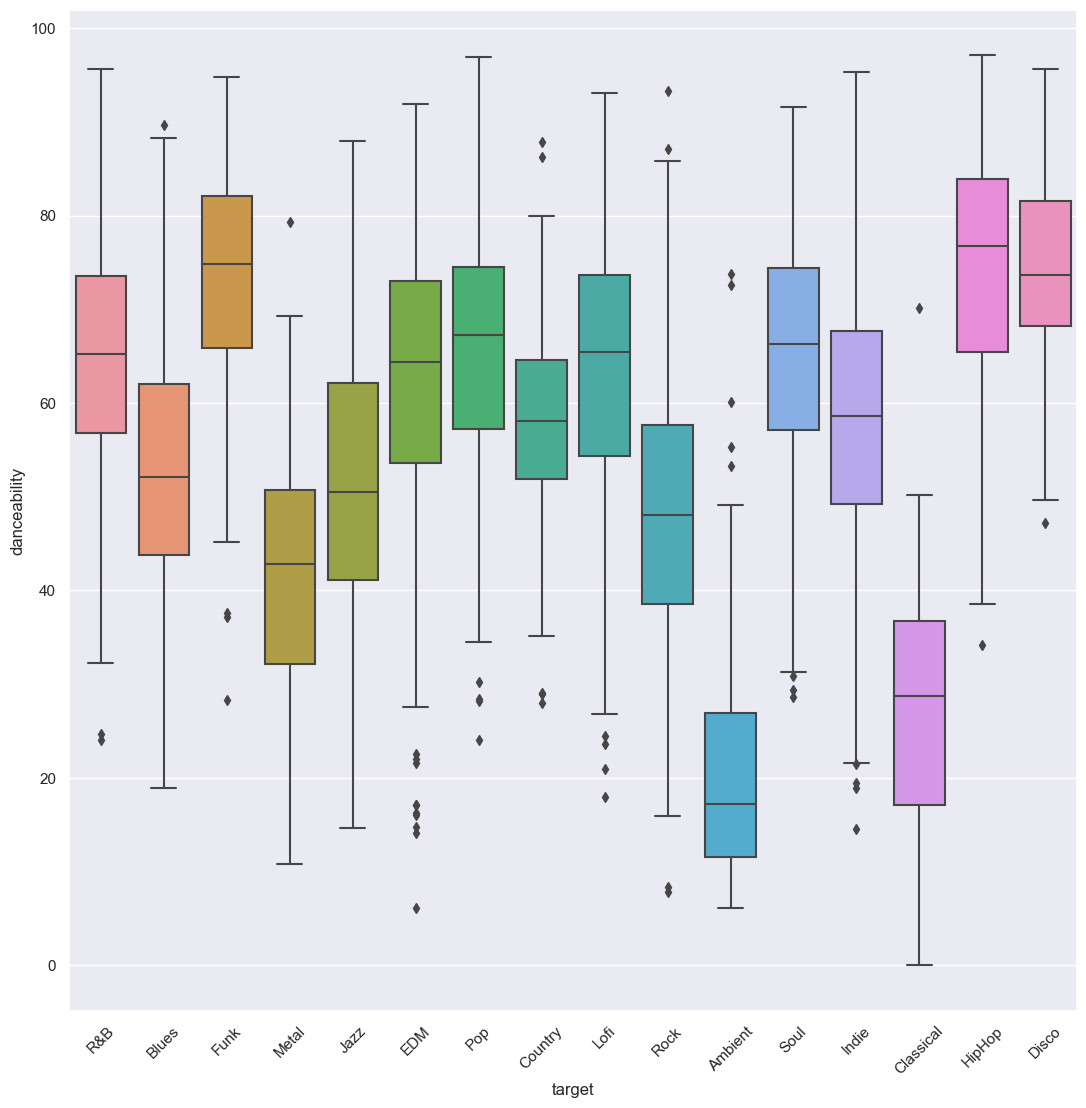

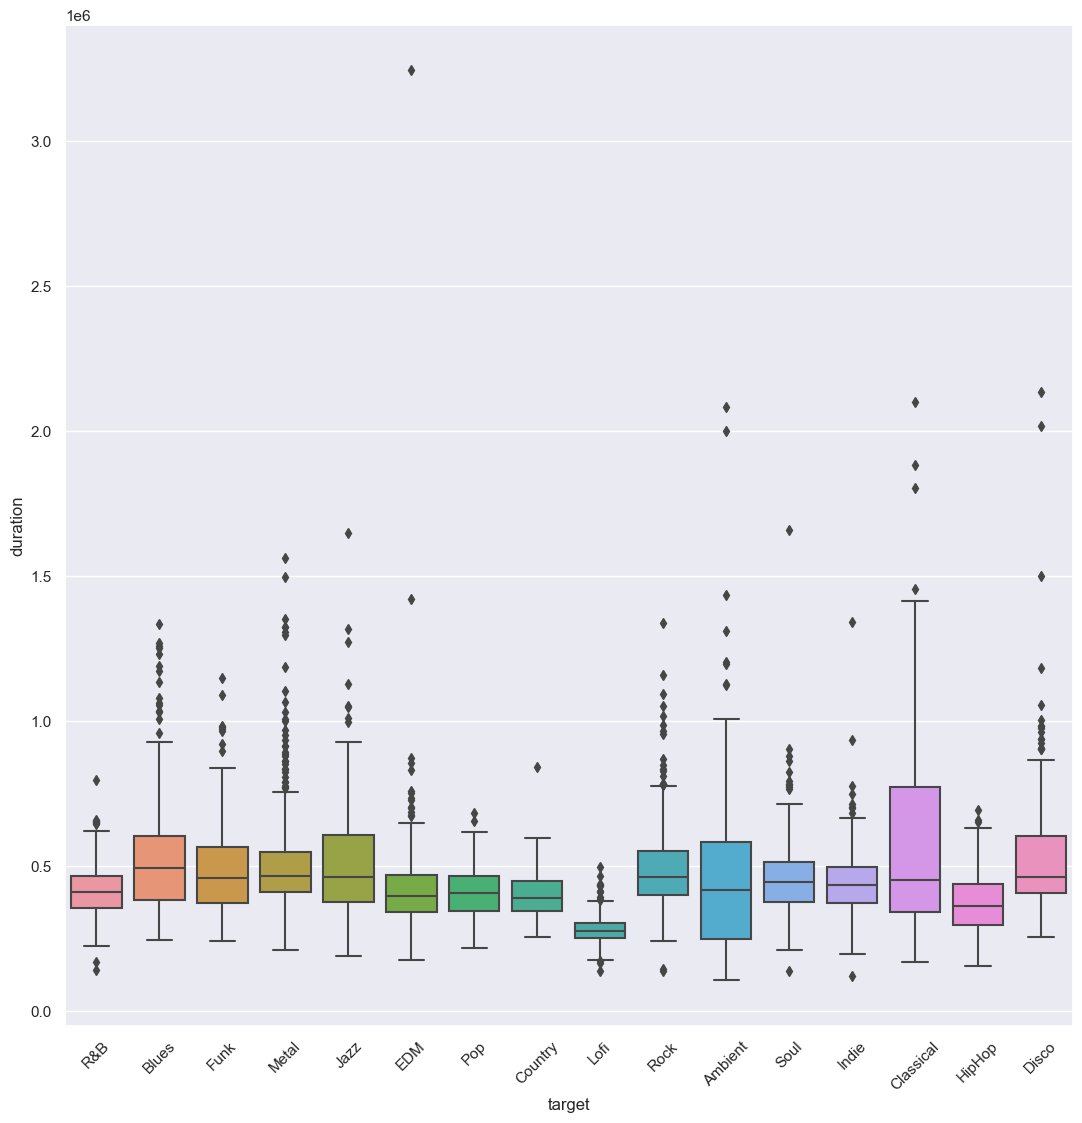

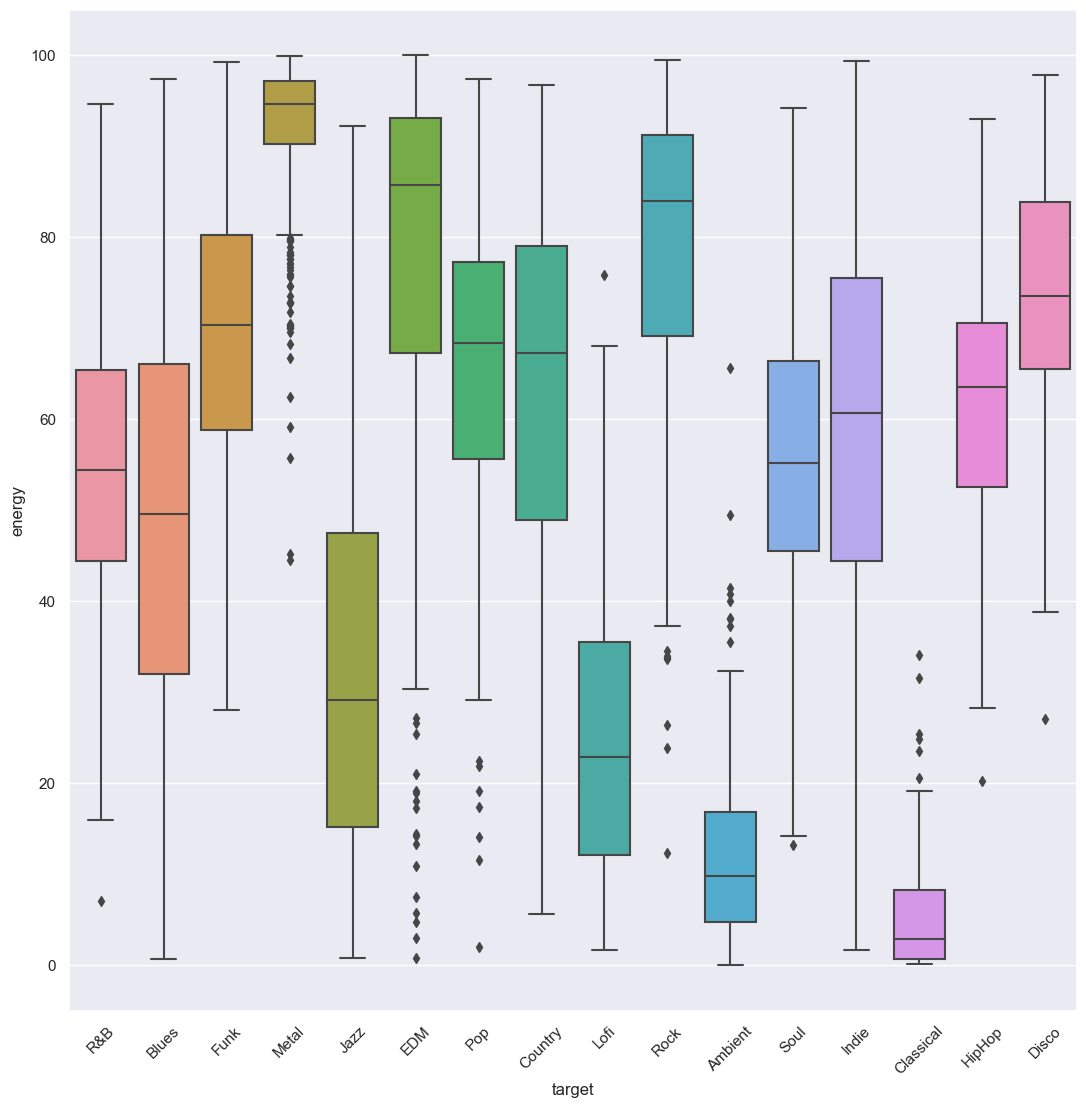

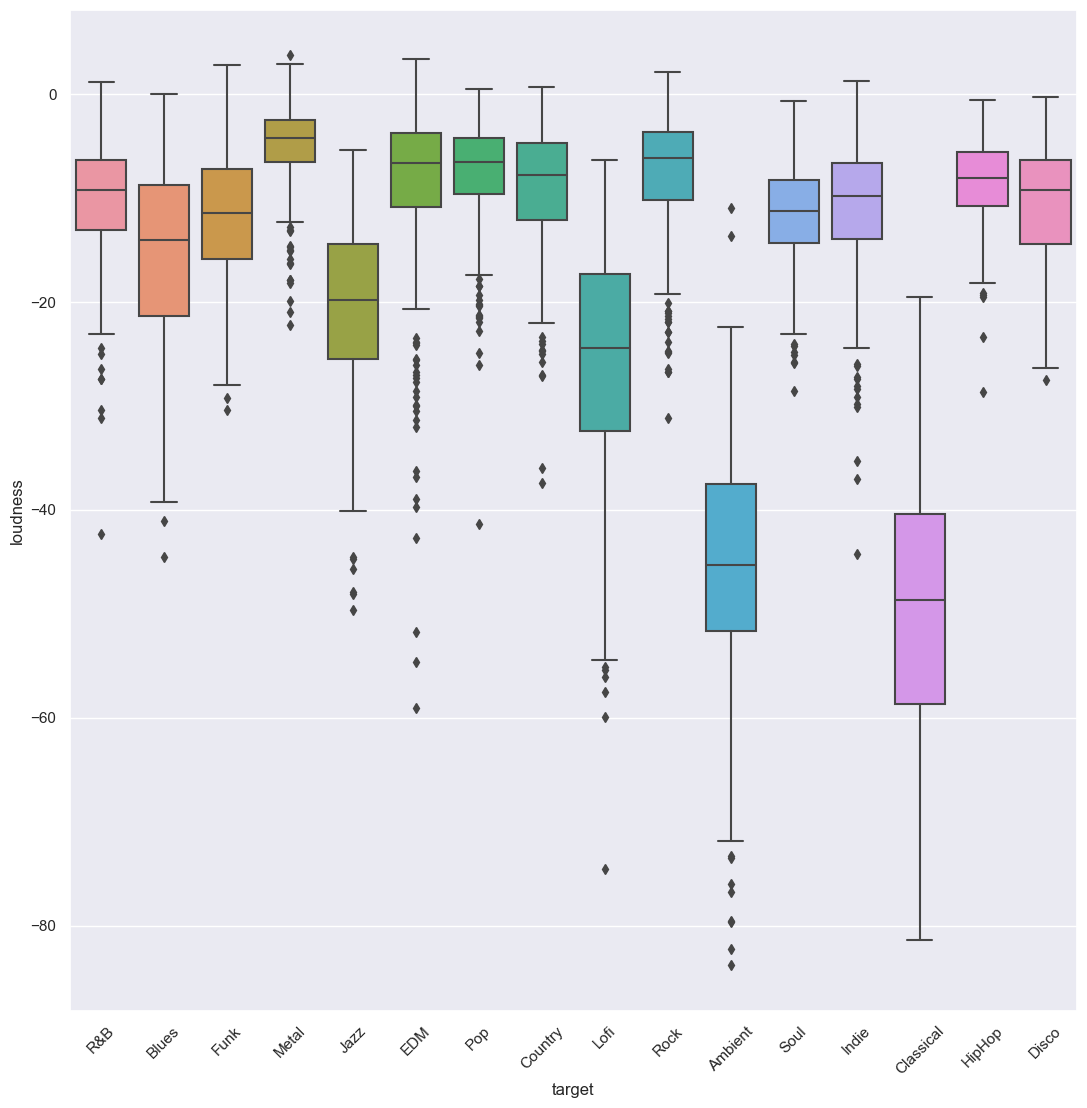

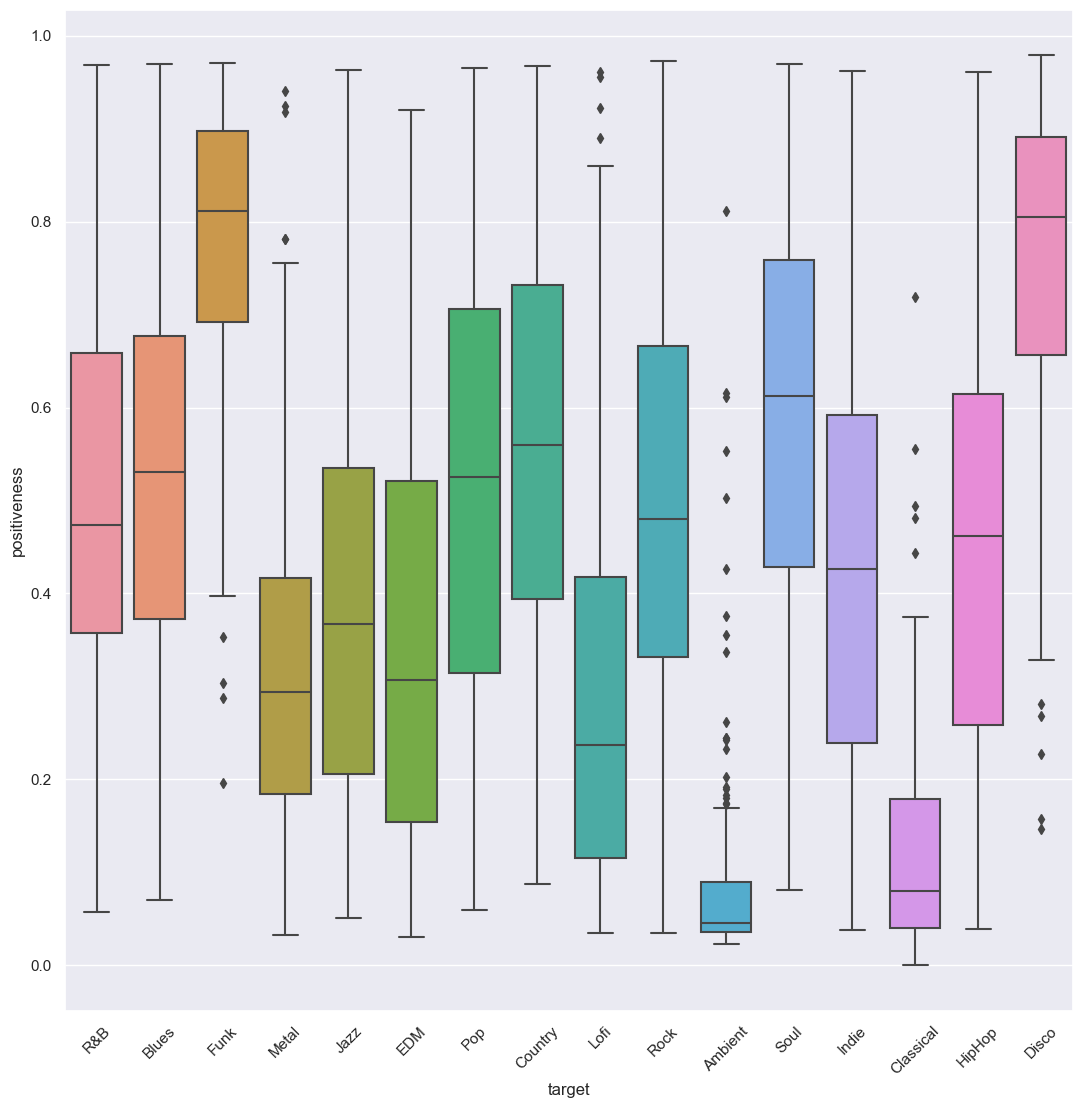

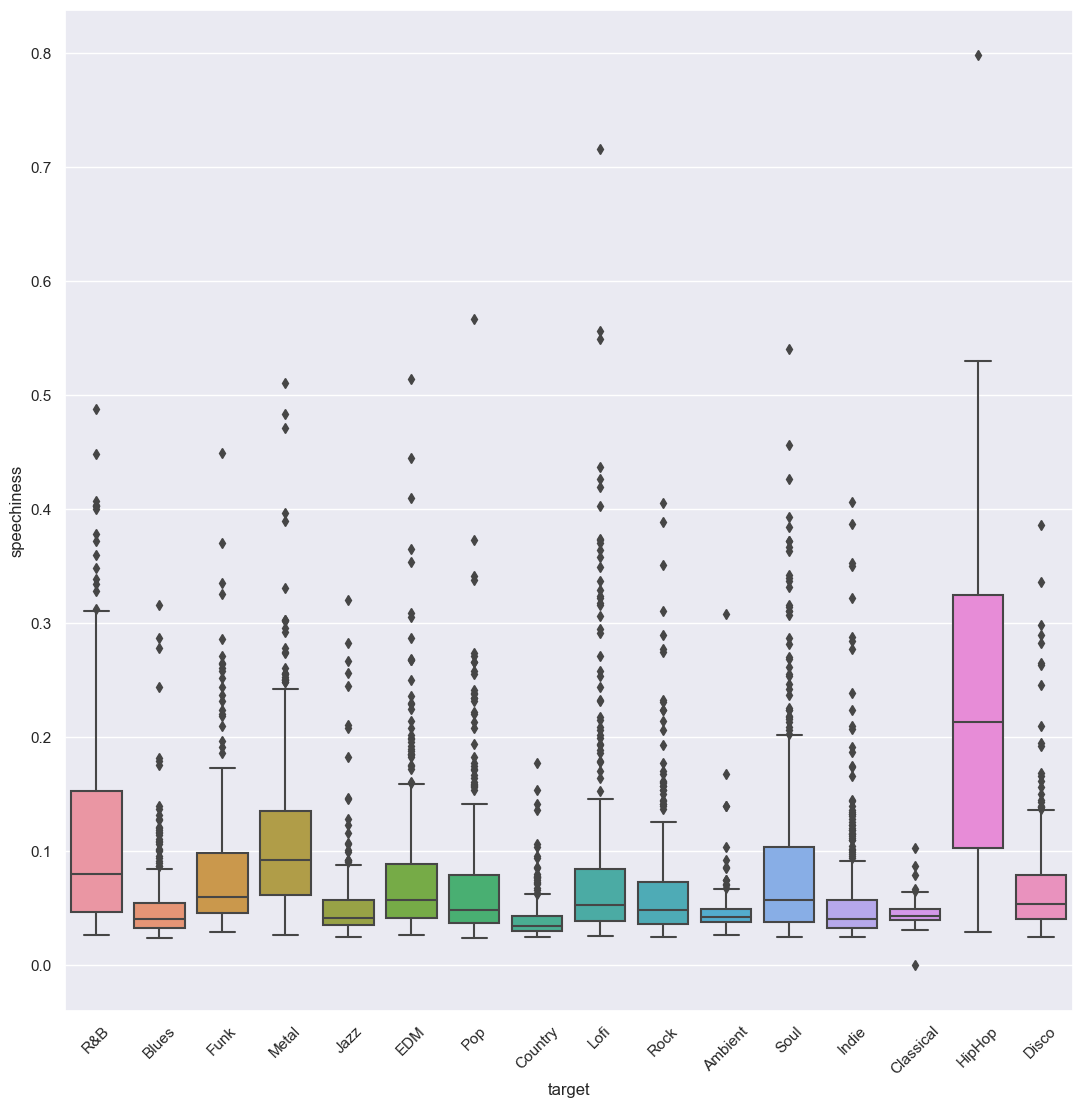

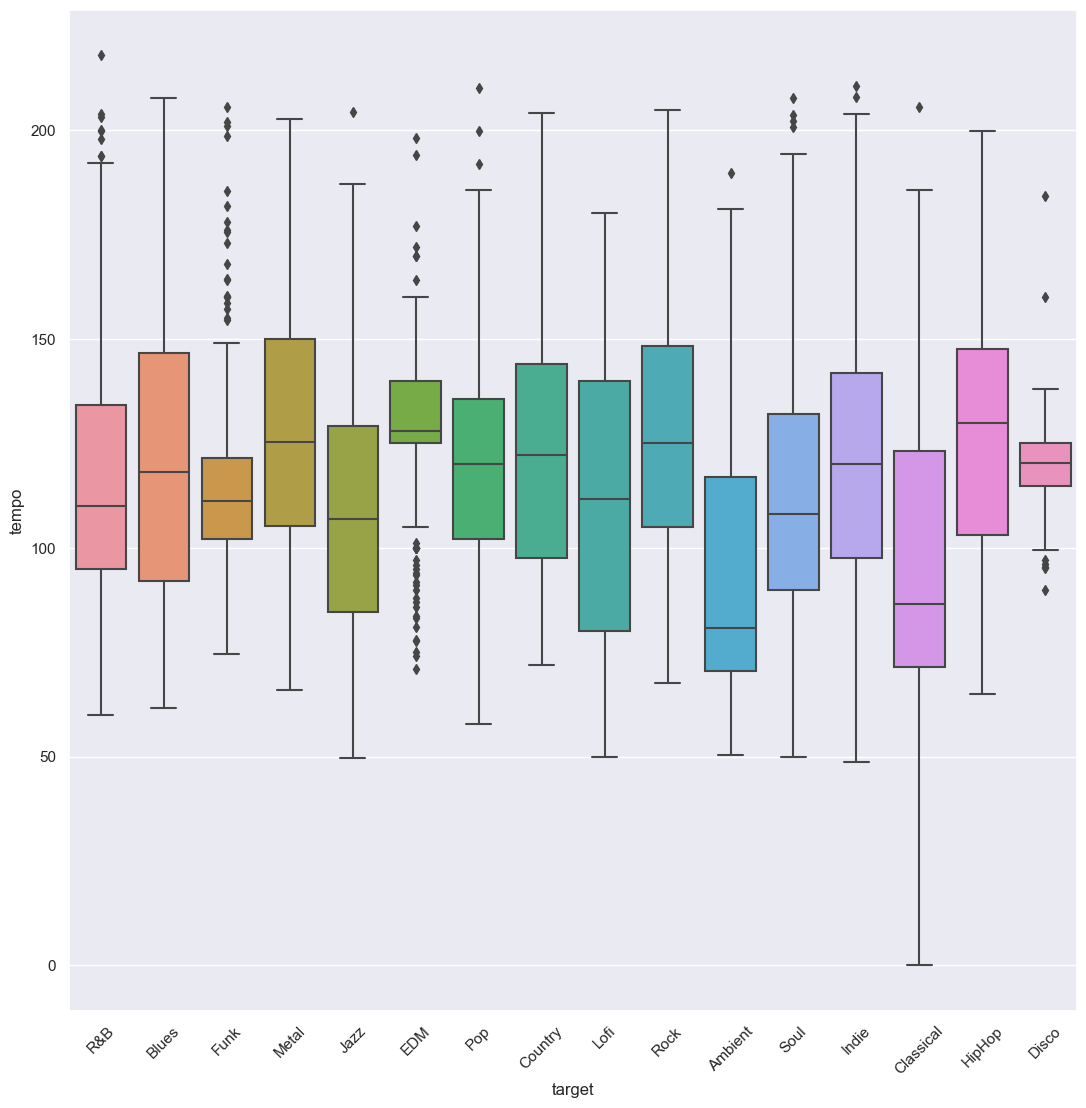

In [106]:
for col in columnsToImpute:
    sns.boxplot(data = merged_df, x = 'target', y = col)
    plt.xticks(rotation = 45)
    plt.show()
    

There are quite a few outliers in all the above boxplots.
* In speechiness graph, we can see that hip-hop and R&B have better ranges.  
* Better to replace by median for each genre for each of the column

In [107]:
dfToImpute = merged_df[['danceability', 'duration', 'energy', 'loudness', 'positiveness', 'speechiness', 'tempo','target']]
dfToImpute = dfToImpute.groupby('target').median()
x = pd.DataFrame(dfToImpute).reset_index()


In [108]:
for col in columnsToImpute:
    merged_df[col] = merged_df[col].fillna(merged_df.groupby('target')[col].transform('median'))
merged_df.isna().sum()

id                    0
adaptibility          0
danceability          0
duration              0
energy                0
explicit              0
happening             0
instrumentalness      0
loudness              0
mode                  0
naturality            0
positiveness          0
release_date          0
reputation            0
speechiness           0
tempo                 0
time_signature        0
total_tracks          0
song_id               0
album                 0
artist                0
lyrics              658
track                 0
target                0
releaseDate           0
dtype: int64

## ANOVA testing for numerical features that help predict the target

In [109]:
num_features = ['adaptibility','danceability','duration','energy','explicit','happening',
               'instrumentalness','loudness','mode','naturality','positiveness',
               'reputation','speechiness','tempo','time_signature','total_tracks']

In [110]:

for feature in num_features:
    # Group the data by the categorical target
    grouped = merged_df.groupby('target')[feature]

    # Perform ANOVA
    f_val, p_val = stats.f_oneway(*[group[1] for group in grouped])

    print(f"Feature: {feature}")
    print("F-value:", f_val)
    print("P-value:", p_val)
    print("\n")

Feature: adaptibility
F-value: 2.1085461867951656
P-value: 0.007366046388662694


Feature: danceability
F-value: 340.9435296797589
P-value: 0.0


Feature: duration
F-value: 54.070277318612305
P-value: 1.5134270762988664e-150


Feature: energy
F-value: 577.1994401906483
P-value: 0.0


Feature: explicit
F-value: 139.1156249916502
P-value: 0.0


Feature: happening
F-value: 15.103607202503719
P-value: 7.604758244775248e-39


Feature: instrumentalness
F-value: 506.62147193271227
P-value: 0.0


Feature: loudness
F-value: 720.9620800704394
P-value: 0.0


Feature: mode
F-value: 18.700331310356347
P-value: 2.0220240893342767e-49


Feature: naturality
F-value: 393.5208283492633
P-value: 0.0


Feature: positiveness
F-value: 212.29286640067517
P-value: 0.0


Feature: reputation
F-value: 220.38194994218912
P-value: 0.0


Feature: speechiness
F-value: 102.22704106988542
P-value: 4.95051493010615e-276


Feature: tempo
F-value: 31.373153828685094
P-value: 1.9439747466825444e-86


Feature: time_signatu

- Features such as "danceability," "energy," "explicit," "instrumentalness," "loudness," "mode," "naturality," "positiveness," "reputation," "speechiness," "tempo," "time_signature," and "total_tracks" all have extremely low p-values (close to 0), indicating a significant impact on predicting the target.
- However, features like "adaptability" and "happening" have higher p-values (0.007 and 7.60e-39, respectively), suggesting some level of contribution to predicting the target but not as strong as the features with near-zero p-values.

## EDA and Visualisation

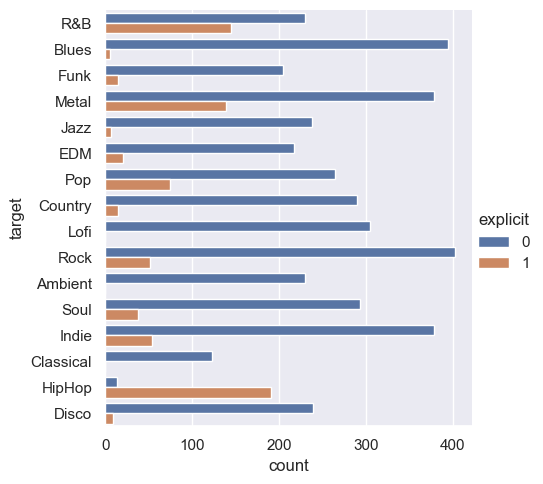

In [111]:
sns.catplot(data=merged_df, y="target",kind="count", hue="explicit")

We can observe that R&B, Metal and Hip-Hop have a lot of explicit content. Whereas classical and lofi have none. 

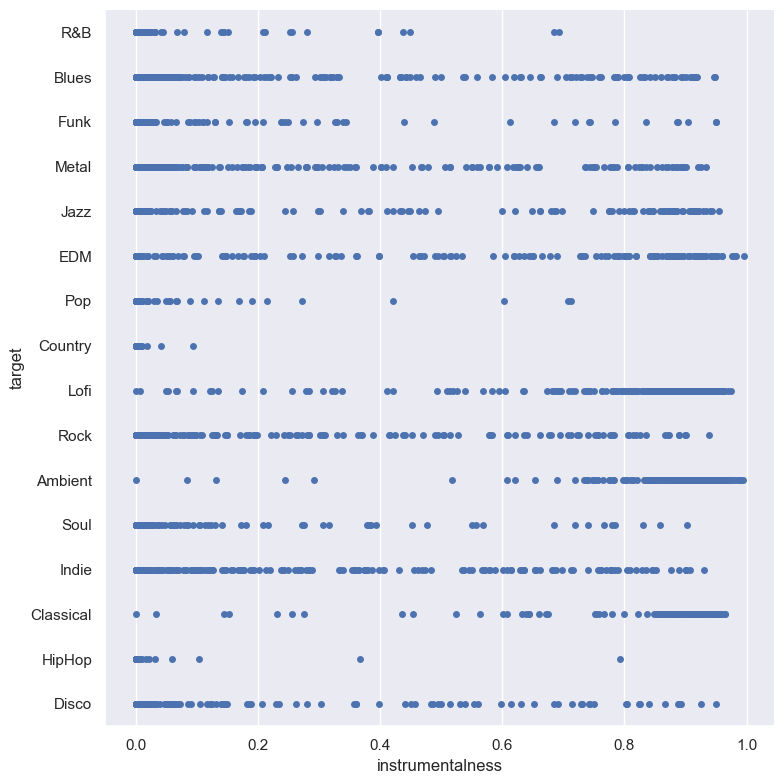

In [112]:
sns.catplot(x="instrumentalness", y="target", jitter= False, data=merged_df, height=8)

In [113]:
merged_df['instrumentalness'].mean()

0.20208298248135456

We observe that lofi, ambient, classical have more values around 1 indicating they have instrumentalness in them. while hip-hop, country, pop, soul, funk, and R&B have values in thelower half. This feature could indeed help us with the genre identification. 
The mean of **instrumentalness** is 0.20 suggesting there are very less songs with no vocals in them.

> Let's look at the ditribution of the numercial features and also their correlations with each other.

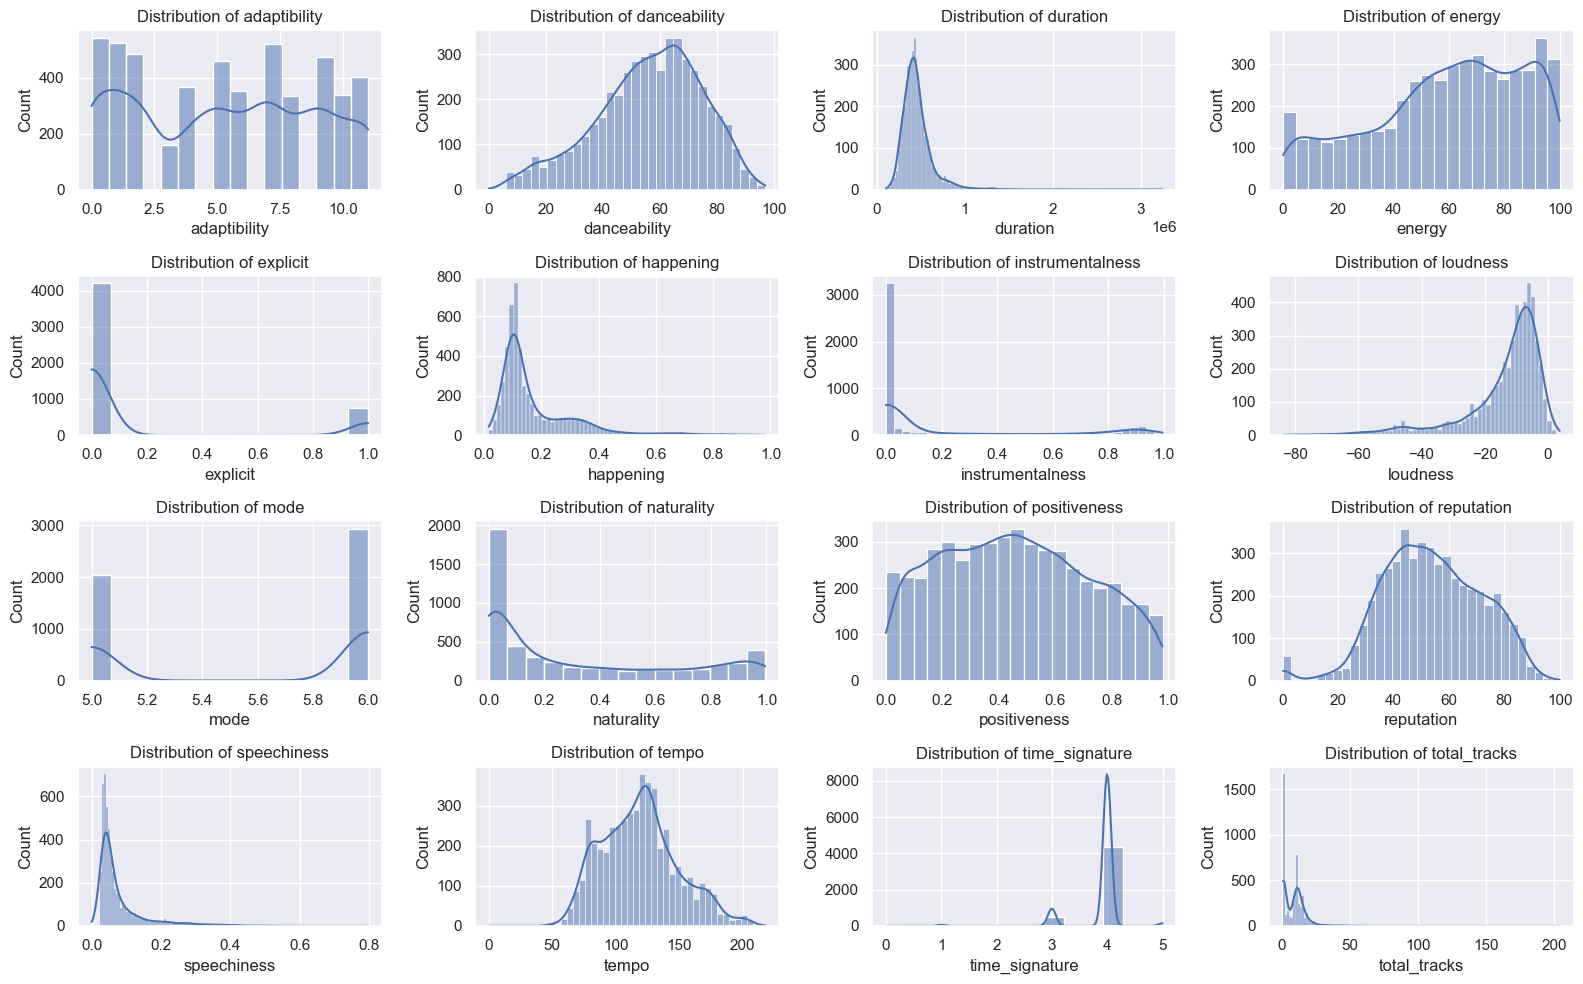

In [114]:
plt.figure(figsize=(16,10))
for i,feature in enumerate(num_features,1):
    plt.subplot(4,4,i)
    sns.histplot(merged_df[feature], kde=True)
    plt.xlabel(feature)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

Do **mode, total_tracks, adaptability, or naturality** help in the cause of predicting the genre of the song? Can we look at dropping these columns?

<Axes: xlabel='positiveness', ylabel='Density'>

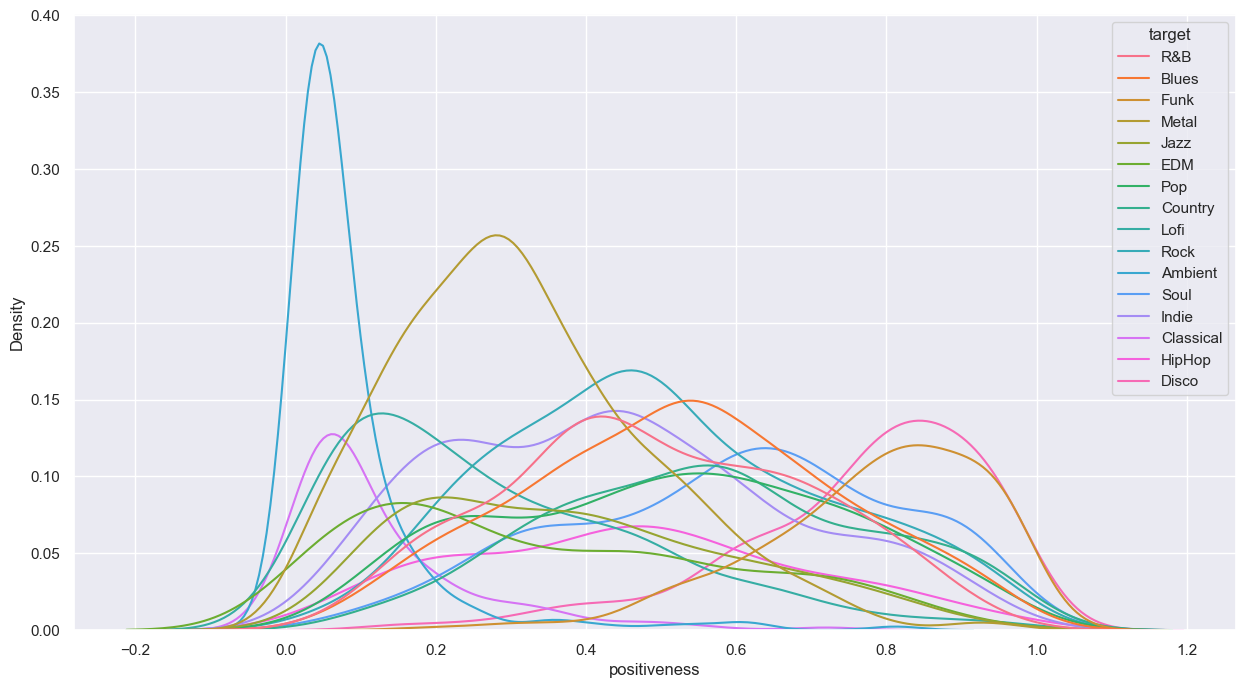

In [115]:
#sns.plot(data=merged_df, y="target",kind="violin", hue="positiveness")
plt.figure(figsize=(15,8))
sns.kdeplot(data=merged_df, x="positiveness", hue="target")


Let's see a plot of positiveness vs explicit

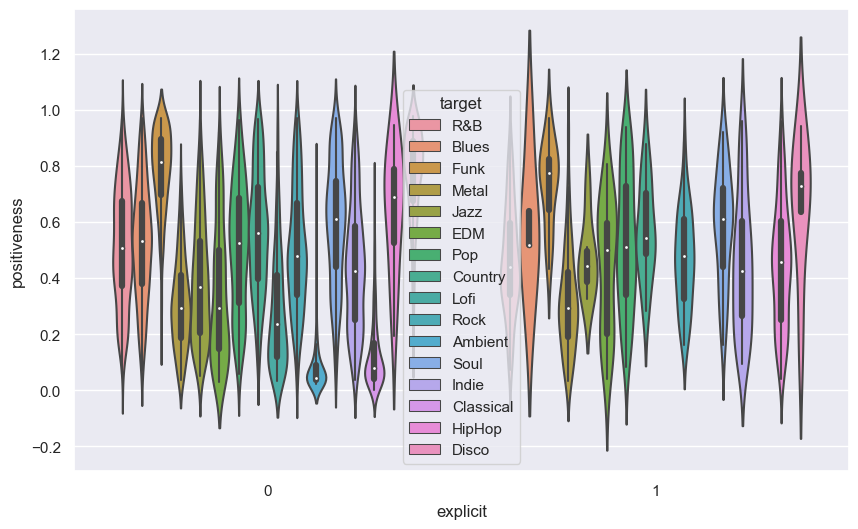

In [116]:
plt.figure(figsize = (10,6))
sns.violinplot(x="explicit", y="positiveness", data=merged_df, scale="width", hue='target')
plt.show()

Are songs with no explicit content have more postiveness? 
For example, hip-hop with explicit content has less positiveness compared to hip-hop tracks with no explicit content. But this pattern does not hold for all genres.
Let's check the bar graph of median value of positivenss across genres. 

Can we replace outliers of each genre by its mean? Can we see if postiveness column, in its entirety, has any outliers that could affect our mean?

<Axes: xlabel='positiveness', ylabel='target'>

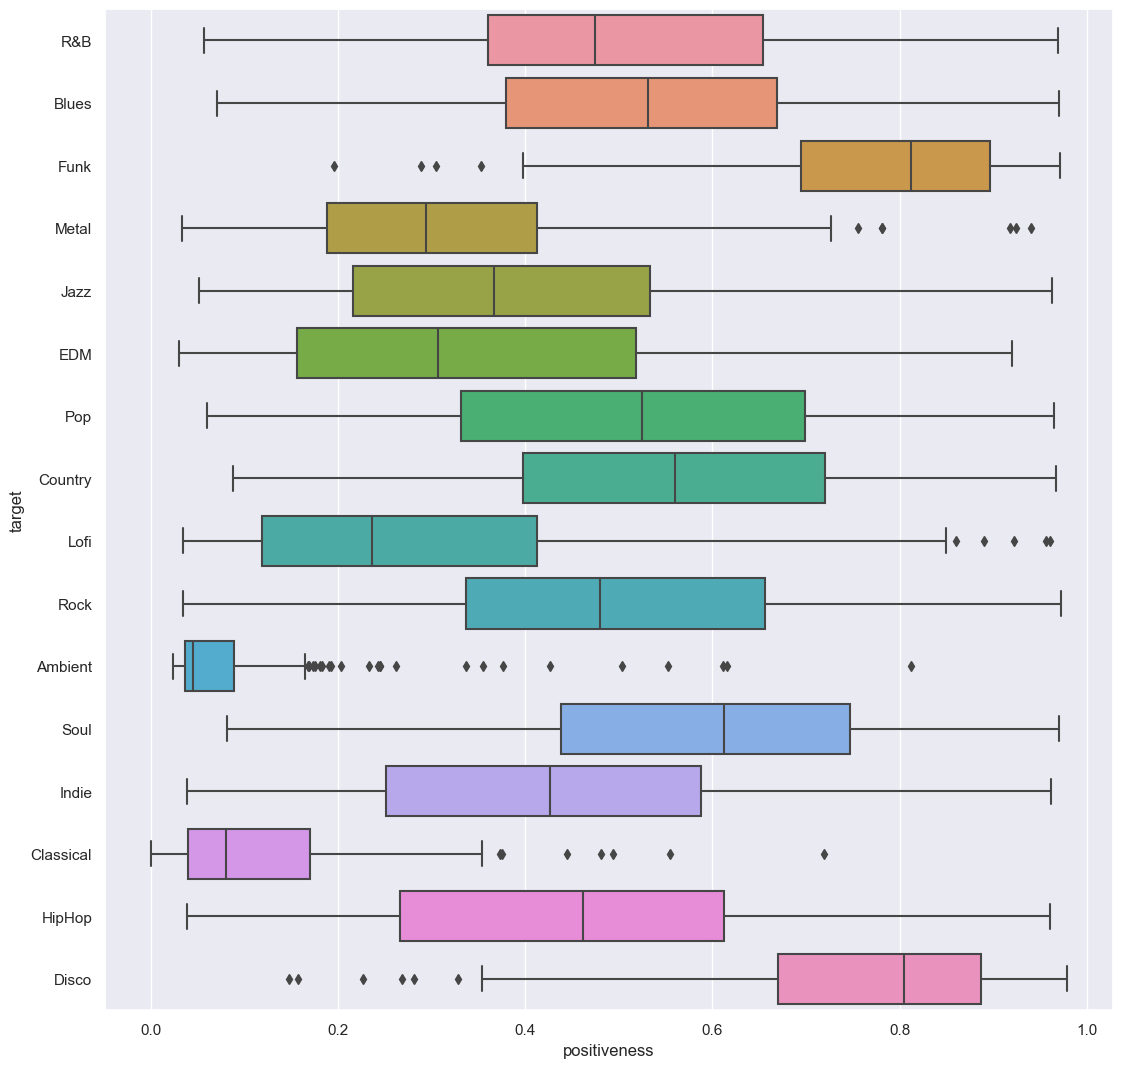

In [117]:
sns.boxplot(x='positiveness', y='target', data=merged_df)

Let's check if duration helps us decide the genre

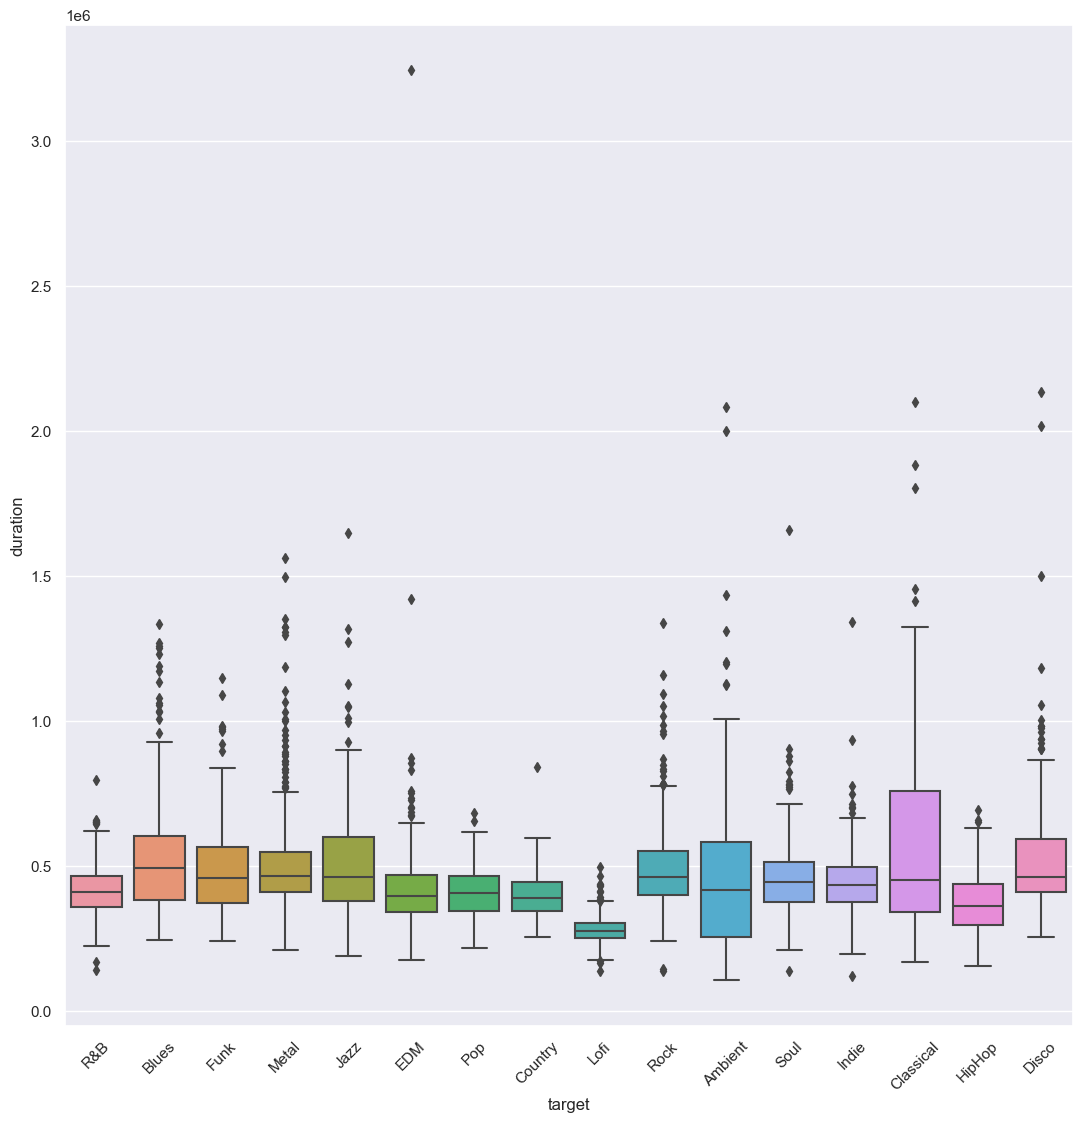

In [118]:
sns.boxplot(data = merged_df, x = 'target', y = 'duration')
plt.xticks(rotation = 45)
plt.show()

Hard to interpret from this graph to cofidently tell whether duration is important in predicting genre. Hopefully the correlation matrix helps.

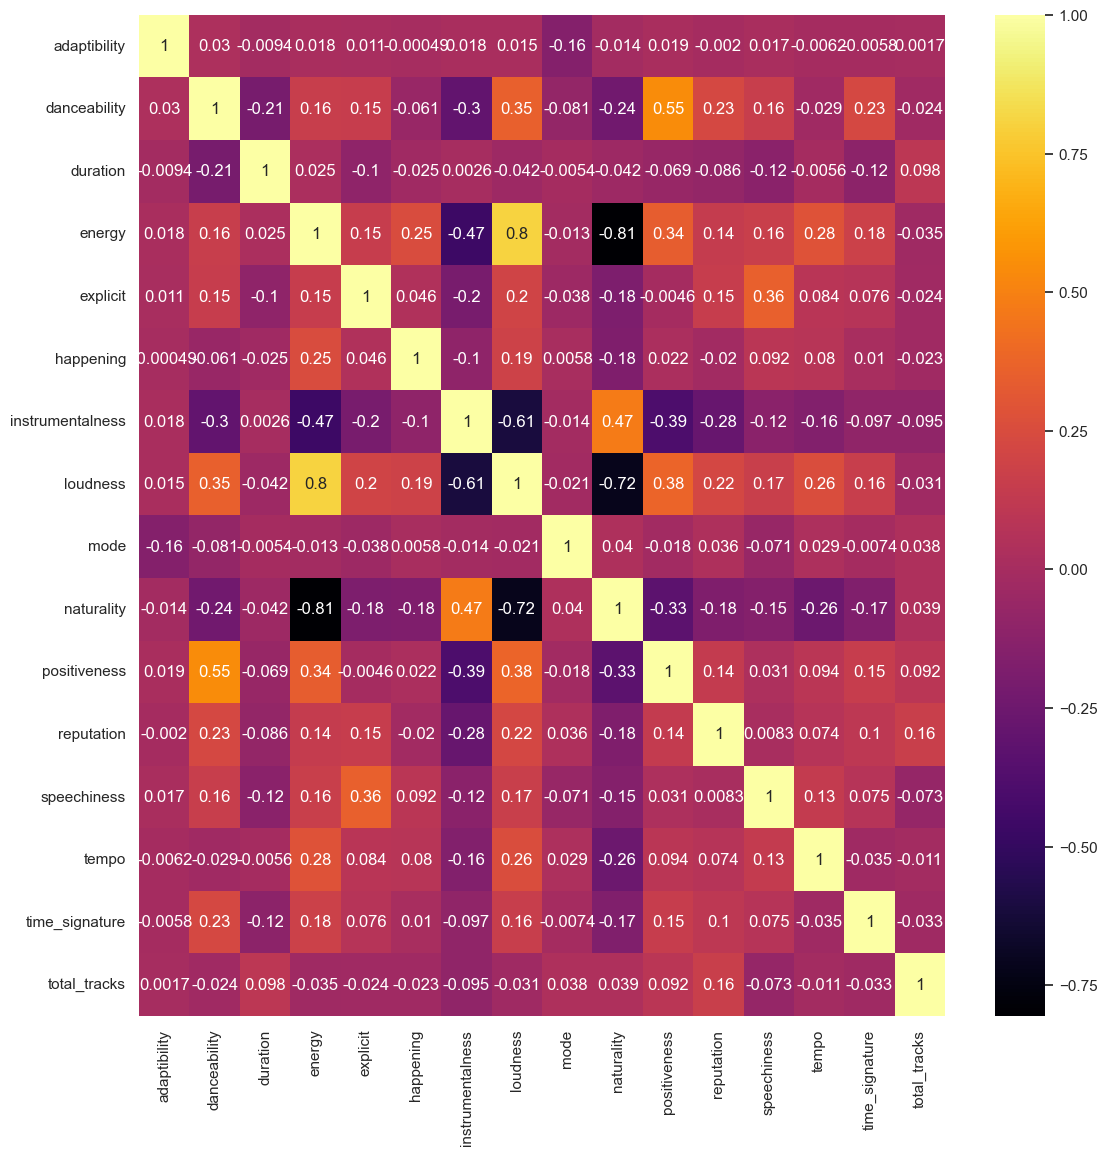

In [119]:
sns.set_theme(rc = {'figure.figsize':(13, 13)})
colormap = sns.color_palette("inferno", as_cmap=True)
sns.heatmap(merged_df[num_features].corr(), cmap=colormap, annot=True)
plt.show()

Dropping the below columns

In [120]:
merged_df.drop(['adaptibility','happening', 'release_date'], inplace = True, axis=1)

Let's process the lyrics, track, and album columns now. I want to use NLP to process these columns. While we could look at one-hot encoding the tracks/albums, I want to choose against doing so as we already have so many categorical features. This will just explode the dimensions of the data.

In [121]:
merged_df['lyrics'].head()

0    2 Contributors2000s R&B Lyrics[Intro: Kenyon D...
1    2 ContributorsMade For Me Lyrics[Intro]\nMm\nO...
2    8 ContributorsGoing Down Lyrics[Verse 1]\nI'm ...
3                                                  NaN
4                                                  NaN
Name: lyrics, dtype: object

In [122]:
merged_df['album'].head()

0              The R&B You Love
1                   Made For Me
2      Getting Ready... (World)
3           The Fearless Flyers
4    Bloomfield-A Retrospective
Name: album, dtype: object

In [123]:
merged_df['track'].head()

0           2000s R&B
1         Made For Me
2          Going Down
3         Ace of Aces
4    Albert's Shuffle
Name: track, dtype: object

Lyrics has a lot of junk values in it. Let's clean that up.

In [124]:
merged_df.shape

(4961, 22)

# Text Cleaning and Pre-processing

Step 1: To replace all the NaNs with blank spaces

* After careful observation of lyrics column, there's a lot of noise and garbage in the text. There are some lyrics that are just conversation snippets or junk. The way to differentiate this from actual lyrics is that actual lyrics have the word 'Lyrics[Intro]' or 'Lyrics[Verse]' or 'Lyrics[Chorus]'
* Also, the end of lyrics has 'Embed' concatenated to the last word of the lyrics. We would need to remove that as well.


In [125]:
#Using regex library to clean text
import re 

merged_df["lyrics"].dropna(inplace=True)

#merged_df['lyrics'].astype(str)
allLyrics = merged_df['lyrics'].fillna(' ')

def checkFirstLine(text):
    lines = text.split('\n')
    if 'Lyrics[' in lines[0] and len(lines) > 1:
        return lines[1:-1]
    ##print('Line 2: ', lines[1])

In [126]:
htmlRegex = re.compile('<.*?>')
allLyrics.str.replace(htmlRegex,'',regex = True) #Removes HTML tags
allLyrics.str.replace('\d+', '') #Removes digits and replaces with nothing
allLyrics = allLyrics.apply(checkFirstLine)


/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_55884/809382972.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  allLyrics.str.replace('\d+', '') #Removes digits and replaces with nothing


In [127]:
allLyrics.head()

0    [Yeah, yeah, yeah, yeah, , [Verse 1: Kenyon Di...
1    [Mm, Oh, , [Verse 1], The smell of your perfum...
2    [I'm going down, I'm going, down, down, down, ...
3                                                 None
4                                                 None
Name: lyrics, dtype: object

In [128]:
!pip install contractions
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')

zsh:1: command not found: pip


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/divyahegde/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Contractions are shortened forms of words that are created by combining two words together and replacing some letters with an apostrophe. For example, "can't" is a contraction of "cannot", "won't" is a contraction of "will not", and "I'm" is a contraction of "I am". There are informal contractions as well in messaging or social media. For example, u is considered a contraction for you. 
Since there's a lot of lyrics which have words in contractions, we will expand them and remove stopwords.

In [129]:
# Function to remove values from each list
def remove_values(row):
    #print('Row: ',row)
    if row == None:
        return ''
    else:
        lst = [char for char in row if '[' not in char] 
        lst = [char for char in lst if char != ' '] 
        lst = [char.strip() for char in lst]
        lst = [char.lower() for char in lst]
        lst = [contractions.fix(char) for char in lst]
        result_str = " ".join(lst)
        #print('list: ',lst)
        return result_str

In [130]:
allLyrics = allLyrics.apply(remove_values)
allLyrics.head()

0    yeah, yeah, yeah, yeah  ran into you yesterday...
1    mm oh  the smell of your perfume i thought i w...
2    i am going down i am going, down, down, down, ...
3                                                     
4                                                     
Name: lyrics, dtype: object

In [131]:
allLyrics.head()
#merged_df.drop(['lyrics'],axis=1,inplace = True)

0    yeah, yeah, yeah, yeah  ran into you yesterday...
1    mm oh  the smell of your perfume i thought i w...
2    i am going down i am going, down, down, down, ...
3                                                     
4                                                     
Name: lyrics, dtype: object

In [132]:
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


In [133]:
def stemLyrics(tokens):
    stemmed_lyrics = [porter_stemmer.stem(word) for word in tokens]
    return stemmed_lyrics

In [134]:
def lemmtizeLyrics(tokens):
    #x = list(map(lemmatizer.lemmatize, tokens))
    #lemmatized_tokens = list(map(lambda x : lemmatizer.lemmatize(x,'v'), x))
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in tokens]
    lemmatized_tokens = list(filter (lambda x : not x in stop_words, lemmatized_tokens))
    return lemmatized_tokens

In [135]:
def preprocessLyrics(row):
    tokens = word_tokenize(row)
    tokens = [re.sub('[^a-zA-Z0-9]+', '', _) for _ in tokens]
    tokens = [i for i in tokens if i != ' ']
    #print('rokens: ',tokens)
    #stemmed = stemLyrics(tokens)
    lemmas = lemmtizeLyrics(tokens)
    return lemmas

In [136]:
allLyrics = list(map(preprocessLyrics, allLyrics))

Lets create word embedding using Word2Vec method. The 2 strategies that word2vec used to create embeddings and thereby establishes semantic relationships between words are Continuous Bag of Words (CBOW) and Skipgrams. CBOW guess the target word when corresponsing context words are provided. Skipgram does the vice versa. I will be using CBOW with different vector size and window size. I'm trying vector sizes 100 and 200. Window sizes 5 and 10. 

Setting vector size to 100 or 200 means each word is represented by a vector of 100 dimensions. Setting window size to 5 means the model will look at considering the context of 5 words before the target and 5 words after the target to predict the target word.

In [137]:
#lyrics_vector_size = [100,200,250]
#window_size = [5,10]

In [138]:
bigrams = Phrases(allLyrics,min_count=1, threshold=1) #creates bi-grams
trigrams = Phrases(bigrams[allLyrics])#creates tri-grams

In [139]:
lyrics_model_100 = Word2Vec(
    sentences = trigrams[bigrams[allLyrics]],
    vector_size = 100,
    min_count=3, window=5, workers=4)

In [140]:
print(lyrics_model_100.wv.most_similar("dance"))

[('sing', 0.9996616840362549), ('close_eye', 0.9995375275611877), ('sweet', 0.9994608759880066), ('shame', 0.9994470477104187), ('every_day', 0.9994344115257263), ('hold_hand', 0.9994199872016907), ('light', 0.999394416809082), ('tight', 0.9993933439254761), ('want_feel', 0.9993876814842224), ('baby_girl', 0.9993828535079956)]


In [141]:
lyrics_model_200 = Word2Vec(
    sentences = trigrams[bigrams[allLyrics]],
    vector_size = 200,
    min_count=3, window=10, workers=4)

In [142]:
print(lyrics_model_200.wv.most_similar("dance"))

[('close_eye', 0.9995289444923401), ('want_feel', 0.9994564652442932), ('might_well', 0.9994232654571533), ('sing', 0.9994072914123535), ('lover', 0.9993590712547302), ('oooh_', 0.999347984790802), ('ahh_', 0.9993353486061096), ('day_night', 0.9993321299552917), ('take_breath', 0.999291718006134), ('could_go', 0.9992608428001404)]


In [143]:
lyrics_model_250 = Word2Vec(
    sentences = trigrams[bigrams[allLyrics]],
    vector_size = 250,
    min_count=3, window=10, workers=4)

In [144]:
print(lyrics_model_250.wv.most_similar("dance"))

[('one_night', 0.9995568990707397), ('lose_mind', 0.9995390772819519), ('going_make', 0.9995097517967224), ('ahh_', 0.9995005130767822), ('sweet', 0.999451220035553), ('make_cry', 0.999440610408783), ('sing', 0.9993648529052734), ('want_feel', 0.9993541240692139), ('day_night', 0.9993264079093933), ('desire', 0.9992933869361877)]


We will also do similar thing for album and track fields. Create word embeddings for the these two columns

In [145]:
album_model = Word2Vec(sentences=[album.split() for album in merged_df['album']],
                       vector_size = 50,
                       min_count=2, window=10, workers=4)

In [146]:
track_model = Word2Vec(sentences=[track.split() for track in merged_df['track']],
                       vector_size = 50,
                       min_count=2, window=10, workers=4)

In [147]:
#Lets check the size of unique word embeddings created by the models
print("Lyrics vocab size with 100 vec size: ", len(lyrics_model_100.wv.index_to_key))
print("Lyrics vocab size with 200 vec size: ", len(lyrics_model_200.wv.index_to_key))
print("Lyrics vocab size with 250 vec size: ", len(lyrics_model_250.wv.index_to_key))
print("Album vocab size: ", len(album_model.wv.index_to_key))
print("Track vocab size: ", len(track_model.wv.index_to_key))

Lyrics vocab size with 100 vec size:  29373
Lyrics vocab size with 200 vec size:  29373
Lyrics vocab size with 250 vec size:  29373
Album vocab size:  1814
Track vocab size:  1656


In [148]:
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')

In [149]:
def word_to_vec(text, vec_size, model, isLyrics = False) -> np.ndarray:
    if isLyrics:
        words = preprocessLyrics(text)
        vectors = [model.wv[word] for word in words if word in model.wv]
    else:
        letters_only = REPLACE_WITH_SPACE.sub(" ", text)
        cleaned_letters = letters_only.lower()
        tokens = word_tokenize(cleaned_letters)
        words = lemmtizeLyrics(tokens)
        vectors = [model.wv[word] for word in words if word in model.wv]
    # If there are vectors, return the mean; otherwise, return a zero vector
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vec_size)

In [150]:
merged_df['lyrics_vector'] = merged_df['lyrics'].apply(lambda x : word_to_vec(x,250, lyrics_model_250, True) if pd.notnull(x) else None)

In [151]:
merged_df['album_vector'] = merged_df['album'].apply(lambda x : word_to_vec(x, 50, album_model, False) if pd.notnull(x) else None)

In [152]:
merged_df['track_vector'] = merged_df['track'].apply(lambda x : word_to_vec(x, 50, album_model, False) if pd.notnull(x) else None)

In [153]:
merged_df.isna().sum()

id                    0
danceability          0
duration              0
energy                0
explicit              0
instrumentalness      0
loudness              0
mode                  0
naturality            0
positiveness          0
reputation            0
speechiness           0
tempo                 0
time_signature        0
total_tracks          0
song_id               0
album                 0
artist                0
lyrics              658
track                 0
target                0
releaseDate           0
lyrics_vector       658
album_vector          0
track_vector          0
dtype: int64

In [154]:
merged_df['lyrics_vector'] = merged_df['lyrics_vector'].fillna(pd.Series([np.zeros(250)] * len(merged_df['lyrics_vector'])))

In [155]:
merged_df.isna().sum()

id                    0
danceability          0
duration              0
energy                0
explicit              0
instrumentalness      0
loudness              0
mode                  0
naturality            0
positiveness          0
reputation            0
speechiness           0
tempo                 0
time_signature        0
total_tracks          0
song_id               0
album                 0
artist                0
lyrics              658
track                 0
target                0
releaseDate           0
lyrics_vector         0
album_vector          0
track_vector          0
dtype: int64

In [156]:
lyrics_vectors_expanded = pd.DataFrame(merged_df['lyrics_vector'].to_list(), columns=[f'lyrics_vector_{i}' for i in range(250)])
print(lyrics_vectors_expanded.shape)

(4961, 250)


In [157]:
track_vectors_expanded = pd.DataFrame(merged_df['track_vector'].to_list(), columns=[f'track_vector_{i}' for i in range(50)])
print(track_vectors_expanded.shape)

(4961, 50)


In [158]:
album_vectors_expanded = pd.DataFrame(merged_df['album_vector'].to_list(), columns=[f'album_vector_{i}' for i in range(50)])
print(album_vectors_expanded.shape)

(4961, 50)


In [159]:
merged_df = pd.concat([merged_df, lyrics_vectors_expanded, album_vectors_expanded, track_vectors_expanded], axis=1)

In [160]:
merged_df.shape

(4961, 375)

In [161]:
merged_df.drop(columns = ['album_vector', 'track_vector', 'lyrics_vector'], inplace = True)

In [162]:
merged_df.columns

Index(['id', 'danceability', 'duration', 'energy', 'explicit',
       'instrumentalness', 'loudness', 'mode', 'naturality', 'positiveness',
       ...
       'track_vector_40', 'track_vector_41', 'track_vector_42',
       'track_vector_43', 'track_vector_44', 'track_vector_45',
       'track_vector_46', 'track_vector_47', 'track_vector_48',
       'track_vector_49'],
      dtype='object', length=372)

## Model Training 

I will be using catboost algorithm here. With catboost there's no need for explicit encoding of categorical features. It internally converts categorical features into numerical values using various techniques, including target encoding and combination of statistics. It also performs better compared to other gradient boosting algorithm.

In [163]:
cols_to_drop = ['song_id', 'id', 'album', 'track', 'lyrics']
merged_df.drop(columns = cols_to_drop, inplace = True)

After we separate the target and train test split, lets encode the target column and scale few features from before.

In [164]:
cat_features = ['artist']
X = merged_df.drop(columns = ['target'])
y = merged_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [165]:
genres = {
    'Blues': 0,
    'Classical': 1, 
    'Country': 2,
    'Disco': 3,
    'EDM': 4,
    'Funk': 5,
    'HipHop': 6,
    'Indie': 7,
    'Jazz': 8,
    'Lofi': 9,
    'Metal': 10,
    'Pop': 11,
    'R&B': 12,
    'Rock': 13,
    'Soul': 14,
    'Ambient': 15
}

y_train_encoded = y_train.map(genres)
y_test_encoded = y_test.map(genres)
#y_encoded

In [166]:
#cols_to_scale = ['danceability', 'duration', 'energy', 
#       'happening', 'instrumentalness', 'loudness', 'naturality',
#       'positiveness', 'speechiness', 'tempo']

cols_to_scale = ['danceability','duration','energy','explicit',
               'instrumentalness','loudness','mode','naturality','positiveness',
               'reputation','speechiness','tempo','time_signature','total_tracks']

scaler = StandardScaler()
scaler.fit_transform(X_train[cols_to_scale])

scaler.transform(X_test[cols_to_scale])

array([[-0.29663067,  0.23532819, -1.04554095, ...,  1.57681166,
         0.26058912,  1.06482473],
       [-0.07608424, -0.7988268 ,  0.67040107, ..., -1.03497636,
         0.26058912,  0.36998444],
       [-2.59784443,  2.65834305, -2.03954069, ...,  1.85161085,
         0.26058912,  0.17145865],
       ...,
       [-0.94751161, -0.27272492,  1.04438843, ..., -0.87253463,
         0.26058912, -0.82117034],
       [-2.44830319,  2.27997127, -1.88261266, ..., -1.59988565,
        -2.15533992, -0.32485585],
       [ 0.63934688, -0.93736663, -0.92454504, ...,  2.04394372,
         0.26058912, -0.52338164]])

In [167]:
X_train.columns[9]

'reputation'

In [168]:
model = CatBoostClassifier(iterations=1500,  
                           learning_rate=0.1,
                           depth=6,  
                           loss_function='MultiClass',
                           classes_count=16,
                           verbose=100,
                           random_seed=42,
                           cat_features=cat_features)
model.fit(X_train, y_train_encoded)

0:	learn: 2.6086996	total: 91.8ms	remaining: 2m 17s
100:	learn: 0.8707404	total: 8.08s	remaining: 1m 51s
200:	learn: 0.5928740	total: 16.3s	remaining: 1m 45s
300:	learn: 0.4771634	total: 24.4s	remaining: 1m 37s
400:	learn: 0.3992573	total: 32.5s	remaining: 1m 28s
500:	learn: 0.3328549	total: 40.6s	remaining: 1m 20s
600:	learn: 0.2788298	total: 48.7s	remaining: 1m 12s
700:	learn: 0.2357180	total: 56.7s	remaining: 1m 4s
800:	learn: 0.2024024	total: 1m 4s	remaining: 56.3s
900:	learn: 0.1745849	total: 1m 12s	remaining: 48s
1000:	learn: 0.1511804	total: 1m 19s	remaining: 39.9s
1100:	learn: 0.1315600	total: 1m 27s	remaining: 31.8s
1200:	learn: 0.1154387	total: 1m 35s	remaining: 23.7s
1300:	learn: 0.1020932	total: 1m 43s	remaining: 15.8s
1400:	learn: 0.0914560	total: 1m 50s	remaining: 7.84s
1499:	learn: 0.0826826	total: 1m 58s	remaining: 0us


In [169]:
predictions = model.predict(X_test)

In [170]:
y_test

4379       Soul
393     Country
1164    Ambient
4478       Rock
731       Blues
         ...   
422        Lofi
95        Blues
4639       Rock
3039    Ambient
2836       Lofi
Name: target, Length: 993, dtype: object

## Classification Report on predictions

In [171]:
'''' 'Blues': 0,
    'Classical': 1, 
    'Country': 2,
    'Disco': 3,
    'EDM': 4,
    'Funk': 5,
    'HipHop': 6,
    'Indie': 7,
    'Jazz': 8,
    'Lofi': 9,
    'Metal': 10,
    'Pop': 11,
    'R&B': 12,
    'Rock': 13,
    'Soul': 14,
    'Ambient': 15 '''

report = classification_report(y_test_encoded, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        74
           1       0.88      0.95      0.91        22
           2       0.86      0.88      0.87        68
           3       0.63      0.67      0.65        43
           4       0.85      0.65      0.73        51
           5       0.65      0.56      0.60        50
           6       0.79      0.71      0.75        38
           7       0.67      0.68      0.67        87
           8       0.82      0.86      0.84        42
           9       0.92      0.96      0.94        57
          10       0.84      0.87      0.86       119
          11       0.65      0.75      0.70        68
          12       0.70      0.72      0.71        90
          13       0.56      0.59      0.58        75
          14       0.51      0.44      0.47        63
          15       0.95      0.89      0.92        46

    accuracy                           0.74       993
   macro avg       0.75   

The classification model did pretty decent with an accuracy of 0.74. From the classification report we see that the model did poorly in classifying the right instances of genre 14 - Soul. This was the lowest. It did really for Lo-Fi classifying 96% of the cases for Lo-Fi correct.

In [172]:
# display the feature importances
imp_zip = zip(model.feature_names_, model.feature_importances_)
imp_df = pd.DataFrame(imp_zip, columns=['features', 'importances'])
imp_df = imp_df.sort_values(by='importances', ascending=False).reset_index(drop=True)
imp_df

,features,importances
0,reputation,11.500679
1,releaseDate,8.415572
2,energy,7.526510
3,danceability,7.406628
4,instrumentalness,7.056603
5,naturality,6.881694
6,positiveness,4.877298
7,artist,4.245955
8,speechiness,4.061200
9,loudness,3.765594


## Conclusion

The model is doing a decent job in classifying the genres with an f1 score of 0.74. Some things that could be made better would be remove the outliers and clean up lyrics more. This may make the model perform much better.
Using the feature importance, we can definitely look at cleaning up important features to help better in classifying.